In [2]:
## coloque os outros códigos antes...

# https://neptune.ai/blog/google-colab-dealing-with-files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install pandas
!pip install numpy
!pip install matplotlib==3.5.3
!pip install docxtpl
from docxtpl import DocxTemplate, InlineImage
from docx.shared import Cm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 16.1 MB/s 
  Created wheel for docxcompose: filename=docxcompose-1.3.7-py3-none-any.whl size=22441 sha256=9b8a34bc3171fc5b8a5365009c466ceea854354b459dc980b0fdae2fcc296532
  Stored in directory: /root/.cache/pip/wheels/bf/c3/e4/e46bf4bb79f3ec7dd616ea74c41983e9794ec677907d77fc88
  Created wheel for python-docx: filename=python_docx-0.8.11-py3-none-any.whl size=184505 sha256=16df3e184864eb4754155591a45646e9f236d889154ead5cd7932e00bacd4798
  Stored in directory: /root/.cache/pip/wheels/32/b8/b2/c4c2b95765e615fe139b0b17b5ea7c0e1b6519b0a9ec8fb34d
Successful

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
planilha = pd.read_excel("/content/drive/My Drive/CNJ-mortes/df_final_ajust.xlsx")
print(len(planilha))

4011


In [5]:
indexes_para_remover = []
for idx in planilha.index:
  if planilha.iloc[idx]["5 - É caso de interesse?"] != "sim: morte interna" and planilha.iloc[idx]["5 - É caso de interesse?"] != "sim: morte externa":
    indexes_para_remover.append(idx)

planilha_filtrada = planilha.drop(labels=indexes_para_remover)

In [6]:
import unicodedata
def strip_accents(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

In [7]:
def combine(counts, percentages):
    fmt = ' {:.2f}% ({})'.format
    return [fmt(p, c) for c, p in zip(counts, percentages)]

In [8]:
def gera_grafico_geral(variavel, planilha_filtrada, titulo="Media e Medianas Gerais", cor="#ba2e2e", eixo_y=(200, 1400, 200), fonttamanho=17, fonttitulo=20, fontlabel=15, x=22, y=10):
  # print(f'Número total de registros vazios: {planilha_filtrada[variavel].isna().sum()}')

  plt.style.use(['ggplot'])
  fig, ax = plt.subplots(figsize=(x,y))
  fig.suptitle(titulo, fontsize=fonttitulo)

  geral_absolute = planilha_filtrada[variavel].value_counts()
  geral_relative = planilha_filtrada[variavel].value_counts(normalize=True)*100
  if geral_relative.size != 0:
    # ax.xticks(range(eixo_y[0], eixo_y[1], eixo_y[2]))
    geral_relative_plt = geral_relative.plot(ax=ax, kind='barh', color=[cor], fontsize=fonttamanho, edgecolor="black")
    ax.bar_label(ax.containers[0], labels=combine(geral_absolute, geral_relative), fontsize=fontlabel)
    plt.xticks(range(eixo_y[0], eixo_y[1], eixo_y[2]))

  return (plt, fig)

def gera_grafico_geral_media(variavel, planilha_filtrada, titulo="Media e Medianas Gerais", cor="#ba2e2e", eixo_y=(200, 1400, 200), fonttamanho=12):
  # Geral
  media_geral = planilha_filtrada[variavel].mean()
  print(f'Média geral de dias: {media_geral}')

  mediana_geral = planilha_filtrada[variavel].median()
  print(f'Mediana geral de dias: {mediana_geral}')

  dict_infos_gerais = {"Média": float("{:.2f}".format(media_geral)), "Mediana": float("{:.2f}".format(mediana_geral))}
  # print(dict_infos_gerais)

  series_dict_infos_geral = pd.Series(dict_infos_gerais)

  plt.style.use(['ggplot'])
  plt.yticks(range(eixo_y[0], eixo_y[1], eixo_y[2]))
  fig, ax = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(8,8))
  ax.set_title(titulo)
  series_dict_infos_geral.plot(ax=ax, kind='barh', color=[cor], fontsize=fonttamanho, edgecolor="black")
  ax.bar_label(ax.containers[0])

  return (plt, fig)

In [9]:
# print(len(planilha_filtrada))

planilha_filtrada_interna = planilha_filtrada[planilha_filtrada["5 - É caso de interesse?"] == "sim: morte interna"]
# print(len(planilha_filtrada_interna))
planilha_filtrada_externa = planilha_filtrada[planilha_filtrada["5 - É caso de interesse?"] == "sim: morte externa"]
# print(len(planilha_filtrada_externa))

In [10]:
# for i in dict_grupos_comorb:
#   print(i,dict_grupos_comorb[i])

In [11]:
from google.colab import files
variaveis =[planilha.loc[:,'54 - Caso a resposta anterior sejam sim, especificar as causas técnico-científicas indicadas na certidão de óbito. Colocar todos os (até) 5 eventos separados por ponto e vírgula(";").'], planilha.loc[:,'55 - Causas indicadas em outros documentos ( colocar no padrão "nome do documento: causa" e separar por ponto e vírgula ";".']]

lista_ajus_obito = []
lista_tudo_obito = []
lista_documentos = []

for n in range(len(variaveis)):
  lista_termos = variaveis[n].to_list()
  for item in lista_termos:
    if pd.notna(item) == True:
      list_causas = []
      if re.search(":|,",item):
        item = re.sub(":|,",";",item)
      causas = item.split(";")
      for c in causas:
        c = c.lower()
        # c = strip_accents(c).lower().strip()
        # c = re.sub("[^\w\s]","",c)
        if len(c) > 2:
          list_causas.append(c.strip())
          lista_tudo_obito.append(c.strip())
      lista_ajus_obito.append(list_causas)

# for n in range(len(variaveis)):
#   lista_termos = variaveis[n].to_list()
#   print(lista_termos)
#   z=input("")
#   for item in lista_termos:
#     if pd.notna(item) == True:
#       if re.search(":|,",item):
#         item = re.sub(":|,",";",item)
#       causas = item.split(";")
#       for c in causas:
#         c = c.lower()
#         # c = strip_accents(c).lower().strip()
#         # c = re.sub("[^\w\s]","",c)
#         if len(c) > 2:
#           list_causas.append(c.strip())
#           lista_tudo_obito.append(c.strip())
#   lista_ajus_obito.append(list_causas)
  




# print(lista_ajus_obito)
# print(len(lista_ajus_obito))
# # print(lista_documentos)
obt = pd.DataFrame(lista_tudo_obito, columns = ["causas"])
print(obt["causas"].value_counts())


var_obt = obt["causas"].value_counts().to_frame()
var_obt.rename(columns = {"causas": "quantidade"},inplace = True)
# var_obt.to_excel("var_causas.xlsx")
# files.download('var_causas.xlsx')
print(var_obt)

nsa                                          1064
choque hipovolêmico                           131
choque hemorrágico                             55
declaração de óbito                            50
traumatismo cranioencefálico                   50
                                             ... 
ação de instrumento corto contundente           1
acidente de trânsito entre moto e carreta       1
lesões perfuro contusos por arma de fogo        1
traumatismo por projétil de arma de fogo        1
instrumentos perfurocontundentes"               1
Name: causas, Length: 1721, dtype: int64
                                           quantidade
nsa                                              1064
choque hipovolêmico                               131
choque hemorrágico                                 55
declaração de óbito                                50
traumatismo cranioencefálico                       50
...                                               ...
ação de instrumento corto contu

In [12]:
planilha_2 = pd.read_excel("/content/drive/My Drive/CNJ-mortes/var_causas.xlsx")

In [13]:
planilha_filtrada_eliminar = planilha_2[planilha_2["classificação"] == 0]
planilha_filtrada_causas = planilha_2[planilha_2["classificação"] == 1]
planilha_filtrada_documentos = planilha_2[planilha_2["classificação"] == 2]

In [14]:
lista_eliminar = planilha_filtrada_eliminar["Unnamed: 0"].to_list() + planilha_filtrada_documentos["Unnamed: 0"].to_list()
print(lista_eliminar)

['nsa', 'violenta', 'tipo de morte', 'do sistema prisional ou de outros órgãos públicos no exercício da função policial', 'em serviço ou em razão dele', 'indeterminada', 'causa indeterminada', 'morte natural', 'natural', 'violenta.', 'ilegível', 'morte violenta', 'tórax e abdome', 'desde que a ação tenha sido praticada sob quaisquer das hipóteses de exclusão de ilicitude', 'tórax e abdômen', 'dependendo de exames complementares', '2 em tórax e 1 abdome). paciente sem sinais vitais na admissão"', 'causa desconhecida', 'sem assistência médica', '"a esclarecer"', '(ilegível)', 'estômago', '"(...) o veículo roubado fora utilizado para praticar um crime de roubo numa fazenda no município de corumbá de goiás', 'sendo que no local deste roubo da fazenda os criminosos entraram em confronto com a polícia militar e acabaram morrendo', 'com múltiplas perfurações (antebraço bilateral', '"óbito sem assistência médica"', 'e que não entraram', 'desde que a ação tenha sido praticada sob quaisquer das 

In [15]:
list_tm = var_obt.index.to_list()
print(len(list_tm))
lista_lp = []
for l in list_tm:
  if l not in lista_eliminar:
    lista_lp.append(l)
print(len(lista_lp))

1721
1497


In [16]:
# print(lista_lp)

df_final = pd.DataFrame(lista_lp, columns = ["causas"])
df_final["causas_rgx"] = df_final["causas"].str.replace('"|\.|\(|\)',"", regex = True).str.strip()
df_final["causas_rgx"] = df_final["causas_rgx"].str.replace('\n'," ", regex = True).str.strip()


list_causas = df_final["causas_rgx"].to_list()
causas_lp = []
for i in list_causas:
  i = strip_accents(i).lower().strip()
  causas_lp.append(i)


df_final["causas_rgx_lp"] = causas_lp

In [17]:
stop = stopwords.words('portuguese')
stop.append("acao")
df_final["causas_sem_stopwords"] = df_final["causas_rgx_lp"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
print(df_final["causas_sem_stopwords"])

0                     choque hipovolemico
1                      choque hemorragico
2            traumatismo cranioencefalico
3                      projetil arma fogo
4                         politraumatismo
                      ...                
1492        instrumento corto contundente
1493       acidente transito moto carreta
1494    lesoes perfuro contusos arma fogo
1495       traumatismo projetil arma fogo
1496     instrumentos perfurocontundentes
Name: causas_sem_stopwords, Length: 1497, dtype: object


In [18]:
dict_stop_causas_lp = {}

lista_tm_stop = df_final["causas_sem_stopwords"].to_list()
lista_tm_normais = df_final["causas"].to_list()
for n,j in zip(lista_tm_stop, lista_tm_normais):
  try:
    a = dict_stop_causas_lp[n]
  except:
    dict_stop_causas_lp[n] = j


## devolvendo pro DF os termos igualados

lista_tm_igualados = []

for k in lista_tm_stop:
  a = dict_stop_causas_lp[k]
  lista_tm_igualados.append(a)

df_final['causas ajustadas'] = lista_tm_igualados

In [19]:
#  var_ajust = df_final['causas ajustadas'].value_counts().to_frame()

# var_ajust.to_excel("var_ajust.xlsx")
# files.download('var_ajust.xlsx')

In [20]:
df_final

,causas,causas_rgx,causas_rgx_lp,causas_sem_stopwords,causas ajustadas
0,choque hipovolêmico,choque hipovolêmico,choque hipovolemico,choque hipovolemico,choque hipovolêmico
1,choque hemorrágico,choque hemorrágico,choque hemorragico,choque hemorragico,choque hemorrágico
2,traumatismo cranioencefálico,traumatismo cranioencefálico,traumatismo cranioencefalico,traumatismo cranioencefalico,traumatismo cranioencefálico
3,projétil de arma de fogo,projétil de arma de fogo,projetil de arma de fogo,projetil arma fogo,projétil de arma de fogo
4,politraumatismo,politraumatismo,politraumatismo,politraumatismo,politraumatismo
...,...,...,...,...,...
1492,ação de instrumento corto contundente,ação de instrumento corto contundente,acao de instrumento corto contundente,instrumento corto contundente,ação de instrumento corto contundente
1493,acidente de trânsito entre moto e carreta,acidente de trânsito entre moto e carreta,acidente de transito entre moto e carreta,acidente transito moto carreta,acidente de trânsito entre moto e carreta
1494,lesões perfuro contusos por arma de fogo,lesões perfuro contusos por arma de fogo,lesoes perfuro contusos por arma de fogo,lesoes perfuro contusos arma fogo,lesões perfuro contusos por arma de fogo
1495,traumatismo por projétil de arma de fogo,traumatismo por projétil de arma de fogo,traumatismo por projetil de arma de fogo,traumatismo projetil arma fogo,traumatismo por projétil de arma de fogo


In [21]:
planilha_saude = pd.read_excel("/content/drive/My Drive/CNJ-mortes/saude_categorias.xlsx")

In [22]:
# fazer o dic da saúde

dict_saude ={}
dic_int_ext = {}
for a,b,c in zip(planilha_saude["Codigo_codicao_saude"], planilha_saude["Categoria_codicaosaude"],planilha_saude["Categoria_externa_interna*"]):
  a = str(a).split('.')[0]
  c = str(c).split('.')[0]
  try:
    f = dict_saude[str(a)]
  except:
    dict_saude[a] = b
    dic_int_ext[a] = c
  
print(dict_saude)
print(dic_int_ext)

{'31': 'ferimento por arma de fogo', '44': 'Não é possível identificar', '34': 'Hemorragia de causa não especificada', '51': 'Sepse', '2': 'ação/agressão de objeto cortante/perfurante/penetrante/contundente não especificado', 'nan': nan, '13': 'Asfixia mecânica por enforcamento/estragulamento/sufocação indireta', '49': 'Pneumonia', '61': 'Traumatismo cranioencefálico e outras formas de traumatismo craniano', '17': 'Decapitação', '22': 'Doenças do aparelho digestivo', '4': 'Acidente de transporte não especificado', '3': 'Acidente / doença do trabalho', '21': 'Doenças do aparelho circulatório', '47': 'Outros transtornos do equilíbrio hidroeletrolítico e ácido-básico', '23': 'Doenças do aparelho respiratório não especificada', '45': 'Neoplasias e outras condições oncológicas', '37': 'Doenças do aparelho geniturinário', '5': 'Afogamento e submersão não especificados', '62': 'Traumatismo de outros órgãos internos, ou politraumatismo, sem causa especificada', '43': 'Morte violenta não especi

In [23]:
dict_text_saude ={}

for a,b, in zip(planilha_saude["Texto"], planilha_saude["Codigo_codicao_saude"]):
  b = str(b).split('.')[0]
  try:
    f = dict_text_saude[str(a)]
  except:
    dict_text_saude[a] = b

  
print(dict_text_saude)



{'"1) que o corpo foi vítima de agressão física por ação de instrumento pérfuro-contundente (projteis de arma de fogo). 2) que sua causa mortis foi hemorragia interna aguda': '31', '"anemia agua por hemotórax à direita por ferimentos por projéteis de arma de fogo"': '31', '"complicação decorridas de lesões sofridas no estabelecimento prisional de luziânia/go"': '44', '"hemorragia externa aguda devido à lesão da artéria (ilegível) comum esquerda e jugular (ilegível) esquerda': '34', '"hemorragia interna aguda provocada por projétil de arma de fogo (paf)"': '31', '"infecção generalizada': '51', '"laudo': '44', '"morte violenta por arma branca"': '2', '"teve como causa mortis traumatismo craniofacial por ferimentos por projéteis de arma de fogo"': '31', 'bo': 'nan', '"traumatismo cranioencefálico decorrente de ação contundente" (fls. 436)': '2', '(b) ação perfuro contundente': '2', '(c) projétil de arama de fogo': '31', '(ilegível) enforcamento': '13', '(xxx) e bradicárdio. necessitou de 

In [24]:
lista_ajust = df_final['causas ajustadas'].to_list()

lista_causas = []
lista_eq =[]
erros = 0
for it in lista_ajust:
  try:
    it = re.sub("\n"," ", it)
    f = dict_text_saude[it]
    aj = dict_saude[str(f)]
    cs = dic_int_ext[str(f)]
    lista_eq.append(aj)
    lista_causas.append(cs)
  except:
    # print(it)
    erros=erros+1
    lista_eq.append(None)
    lista_causas.append(None)

# print(erros)
# print(lista_eq)

# ajuste nos erros (6)

# for a in range(len(lista_eq)):
#   if lista_eq[a] == None:
#     print(a)

lista_eq[512] = 'ferimento por arma de fogo'
lista_causas[512] = "Externa"
lista_eq[652] = 'ferimento por arma de fogo'
lista_causas[652] = "Externa"
lista_eq[684] = 'ferimento por arma de fogo'
lista_causas[684] = "Externa"
lista_eq[982] = "ação/agressão de objeto cortante/perfurante/penetrante/contundente não especificado"
lista_causas[982] = "Externa"
lista_eq[1178] = "Traumatismo cranioencefálico e outras formas de traumatismo craniano"
lista_causas[1178] = "Externa"
lista_eq[1440] = 'ferimento por arma de fogo'
lista_causas[1440] = "Externa"

In [25]:
df_final["causas_finais"] = lista_eq
df_final["tipo_causas"] = lista_causas
df_final

,causas,causas_rgx,causas_rgx_lp,causas_sem_stopwords,causas ajustadas,causas_finais,tipo_causas
0,choque hipovolêmico,choque hipovolêmico,choque hipovolemico,choque hipovolemico,choque hipovolêmico,Doenças do aparelho circulatório,Natural
1,choque hemorrágico,choque hemorrágico,choque hemorragico,choque hemorragico,choque hemorrágico,Hemorragia de causa não especificada,Externa
2,traumatismo cranioencefálico,traumatismo cranioencefálico,traumatismo cranioencefalico,traumatismo cranioencefalico,traumatismo cranioencefálico,Traumatismo cranioencefálico e outras formas d...,Externa
3,projétil de arma de fogo,projétil de arma de fogo,projetil de arma de fogo,projetil arma fogo,projétil de arma de fogo,ferimento por arma de fogo,Externa
4,politraumatismo,politraumatismo,politraumatismo,politraumatismo,politraumatismo,"Traumatismo de outros órgãos internos, ou poli...",Externa
...,...,...,...,...,...,...,...
1492,ação de instrumento corto contundente,ação de instrumento corto contundente,acao de instrumento corto contundente,instrumento corto contundente,ação de instrumento corto contundente,ação/agressão de objeto cortante/perfurante/pe...,Externa
1493,acidente de trânsito entre moto e carreta,acidente de trânsito entre moto e carreta,acidente de transito entre moto e carreta,acidente transito moto carreta,acidente de trânsito entre moto e carreta,Acidente de transporte não especificado,Externa
1494,lesões perfuro contusos por arma de fogo,lesões perfuro contusos por arma de fogo,lesoes perfuro contusos por arma de fogo,lesoes perfuro contusos arma fogo,lesões perfuro contusos por arma de fogo,ferimento por arma de fogo,Externa
1495,traumatismo por projétil de arma de fogo,traumatismo por projétil de arma de fogo,traumatismo por projetil de arma de fogo,traumatismo projetil arma fogo,traumatismo por projétil de arma de fogo,ferimento por arma de fogo,Externa


Parte de gerar os nós e as relações - ajustando a planilha

In [26]:
##  usar isso aqui pra gerar os nos e as relações
def ajuste_lista_causas(df_final,planilha):
  v_1 = planilha.loc[:,'54 - Caso a resposta anterior sejam sim, especificar as causas técnico-científicas indicadas na certidão de óbito. Colocar todos os (até) 5 eventos separados por ponto e vírgula(";").']
  v_2 = planilha.loc[:,'55 - Causas indicadas em outros documentos ( colocar no padrão "nome do documento: causa" e separar por ponto e vírgula ";".']


  invalidos= ["sem informacao", "sem informacoes","si","nan","None","nsa"]
  lista_causas_lp =[]
  vazios =0
  for a,b in zip(v_1,v_2):
    a = strip_accents(str(a)).lower().strip()
    b = strip_accents(str(b)).lower().strip()
    lista_cs_aj = []
    if a not in invalidos and b not in invalidos:
      # print(a+","+b)
      total = a+","+b
      total = re.sub(":|;",",", total)
      itens = total.split(",")
      for c in itens:
        if c.strip() not in lista_cs_aj:
          lista_cs_aj.append(c.strip())
    elif a not in invalidos and b in invalidos:
      total = a
      total = re.sub(":|;",",", total)
      itens = total.split(",")
      for c in itens:
        if c.strip() not in lista_cs_aj:
          lista_cs_aj.append(c.strip())
    elif a in invalidos and b not in invalidos:
      total = b
      total = re.sub(":|;",",", total)
      itens = total.split(",")
      for c in itens:
        if c.strip() not in lista_cs_aj:
          lista_cs_aj.append(c.strip())
    elif a in invalidos and b in invalidos:
      vazios = vazios+ 1
    lista_causas_lp.append(lista_cs_aj)
  
  print(vazios)
  print(len(lista_causas_lp))
  print(lista_causas_lp)

  relacoes_ajust = []
  causas_ajust = []
  for sub in lista_causas_lp:
    list_mud = []
    list_cs = []
    for it in sub:
      try:
        # print(it)
        idx = df_final[df_final["causas"] == it].index.to_list()
        # print(idx)
        nm = df_final.loc[idx[0],'causas_finais']
        list_mud.append(nm)
        cs = df_final.loc[idx[0],'tipo_causas']
        list_cs.append(cs)
      except:
      #   nm = it
      #   list_mud.append(nm)
        pass
    relacoes_ajust.append(list_mud)
    causas_ajust.append(list_cs)

  print(len(relacoes_ajust))
  print(relacoes_ajust)
  print(causas_ajust)

  return relacoes_ajust, causas_ajust



In [27]:
planilha["causas_morte_ajustadas"],planilha["causas_morte_int_ext"] = ajuste_lista_causas(df_final,planilha)


2859
4011
[['politraumatismo', 'hemorragia interna', 'acao contundente'], ['ferimento perfuro cortante cervical', 'arma branca'], ['politraumatismo', 'queda de altura', 'choque eletrico corrente artificial'], ['lesoes perfuro-contundentes', 'laudo de exame cadaverico'], ['laudo cadaverico', 'lesao perfuro-contundente', 'choque hipovolemico', 'hemorragia interna'], ['laudo cadaverico', 'traumatismo cranioencefalico'], ['traumatismo cranioencefalico', 'ferimentos pro projeteis de arma de fogo', 'laudo cadaverico', 'traumatismo cranioencefalico provocado por lesao perfuro-contundente.'], ['traumatismo cranio encefalico provocado por projetil de arma de fogo'], ['choque hipovolemico', 'trauma abdominal fechado', 'instrumento perfuro-cortante'], ['choque hipovolemico', 'ferimento por paf'], ['parada cardiaca', 'ferimento no torax (parte nao identificada)'], ['politraumatismo', 'traumatismo cranioencefalico e toraxico por arma de fogo'], ['asfixia mecanica por enforcamento'], ['politraumatis

In [28]:
indexes_para_remover = []
for idx in planilha.index:
  if planilha.iloc[idx]["5 - É caso de interesse?"] != "sim: morte interna" and planilha.iloc[idx]["5 - É caso de interesse?"] != "sim: morte externa":
    indexes_para_remover.append(idx)

planilha_filtrada = planilha.drop(labels=indexes_para_remover)

planilha_filtrada_interna = planilha_filtrada[planilha_filtrada["5 - É caso de interesse?"] == "sim: morte interna"]
# print(len(planilha_filtrada_interna))
planilha_filtrada_externa = planilha_filtrada[planilha_filtrada["5 - É caso de interesse?"] == "sim: morte externa"]
# print(len(planilha_filtrada_externa))

gerando os nós e as relações

In [29]:
 ### gerar a lista de nós do óbito e da relações

def gera_nos(relacoes_ajust,causas_ajust):

  lista_unicos= []
  causa_unicos =[]
  for sublist, cs in zip(relacoes_ajust,causas_ajust):
    for sub, c in zip(sublist,cs):
      if sub.strip() not in lista_unicos:
        lista_unicos.append(sub.strip())
        causa_unicos.append(c)
    
  ids = []
  for k in range(len(lista_unicos)):
    ids.append(k)

  lista_nos = pd.DataFrame()
  lista_nos["Label"] = lista_unicos
  lista_nos["Id"] = ids
  lista_nos["causas"] = causa_unicos

  # print(lista_nos)

  lista_nos.to_csv("lista_nos_morte_externa.csv", index= False, encoding= 'utf-8')
  files.download('lista_nos_morte_externa.csv')

  return lista_unicos, ids


##########################################################


def gera_relacoes(lista_unicos, ids, relacoes_ajust):


  dict_ids = {}

  source = []
  target = []
  for id,lb in zip(ids, lista_unicos):
    dict_ids[lb]= id

  for sublist in relacoes_ajust:
      # print(sublist)
      for d in range(len(sublist)):
        # print(sublist[d].strip())
        # z= input("")
        id_source = dict_ids[sublist[d].strip()]
        if d == len(sublist)-1:
          pass
        else:
          for e in range(d+1, len(sublist)):
            source.append(id_source)
            id_target = dict_ids[sublist[e].strip()]
            target.append(id_target)
          # print(source)
          # print(target)
          # z = input("")

  relacoes = pd.DataFrame()

  relacoes["Source"] = source
  relacoes["Target"] = target
  relacoes["Type"] = "Directed"
    
  print(relacoes)
  relacoes.to_csv("relacoes_morte_externa.csv", index= False)
  files.download("relacoes_morte_externa.csv")

In [ ]:
relacoes_ajust = planilha_filtrada_interna["causas_morte_ajustadas"].to_list()
causas_ajust = planilha_filtrada_interna["causas_morte_int_ext"].to_list()

lista_unicos, ids = gera_nos(relacoes_ajust, causas_ajust)
gera_relacoes(lista_unicos, ids, relacoes_ajust)

gerando os dados agora

In [44]:
dados_54 = planilha_filtrada_externa.loc[:,'54 - Caso a resposta anterior sejam sim, especificar as causas técnico-científicas indicadas na certidão de óbito. Colocar todos os (até) 5 eventos separados por ponto e vírgula(";").']

In [45]:
invalidos= ["sem informacao", "sem informacoes","si","nan","None","nsa"]

com_info = 0
sem_info = 0
for item in dados_54:
  item  = strip_accents(str(item)).lower().strip()
  if str(item) not in invalidos:
    com_info = com_info+1
  else:
    sem_info = sem_info +1

print(com_info)
print(sem_info)

810
242


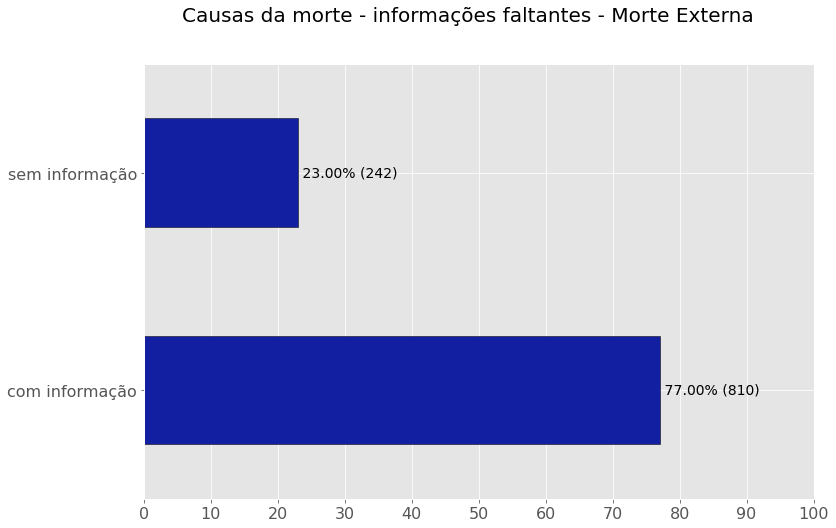

In [48]:
df_totais =pd.DataFrame([810,242],index = ["com informação", "sem informação"], columns =["quantidade"])
df_totais["percentual"] = (df_totais["quantidade"]*100)/1052
# print(df_totais)


plt.style.use(['ggplot'])
fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("Causas da morte - informações faltantes - Morte Externa", fontsize=20)

geral_absolute = df_totais["quantidade"]
geral_relative = df_totais["percentual"]
if geral_relative.size != 0:
  # ax.xticks(range(eixo_y[0], eixo_y[1], eixo_y[2]))
  geral_relative_plt = geral_relative.plot(ax=ax, kind='barh', color= '#121fa1', fontsize=16, edgecolor="black")
  ax.bar_label(ax.containers[0], labels=combine(geral_absolute, geral_relative), fontsize=14)
  plt.xticks(range(0, 110, 10))

In [49]:
dados_54 = planilha_filtrada_interna.loc[:,'54 - Caso a resposta anterior sejam sim, especificar as causas técnico-científicas indicadas na certidão de óbito. Colocar todos os (até) 5 eventos separados por ponto e vírgula(";").']

In [50]:
invalidos= ["sem informacao", "sem informacoes","si","nan","None","nsa"]

com_info = 0
sem_info = 0
for item in dados_54:
  item  = strip_accents(str(item)).lower().strip()
  if str(item) not in invalidos:
    com_info = com_info+1
  else:
    sem_info = sem_info +1

print(com_info)
print(sem_info)

83
33


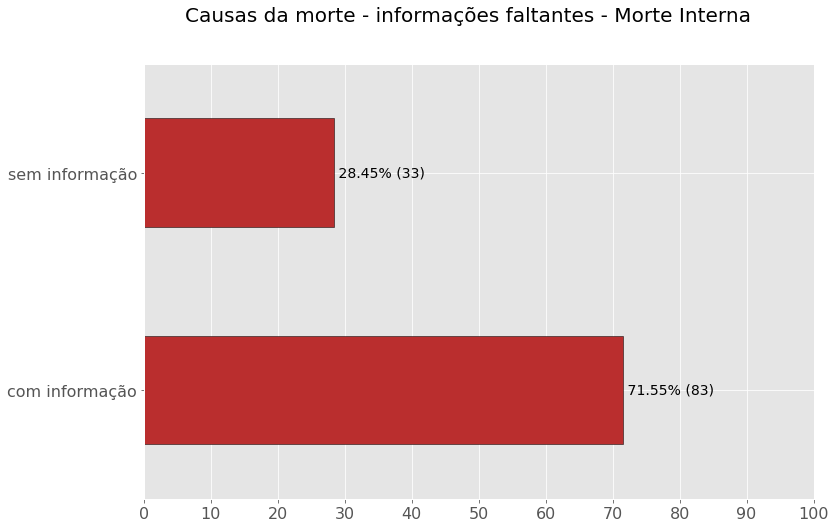

In [52]:
df_totais =pd.DataFrame([83,33],index = ["com informação", "sem informação"], columns =["quantidade"])
df_totais["percentual"] = (df_totais["quantidade"]*100)/116
# print(df_totais)


plt.style.use(['ggplot'])
fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("Causas da morte - informações faltantes - Morte Interna", fontsize=20)

geral_absolute = df_totais["quantidade"]
geral_relative = df_totais["percentual"]
if geral_relative.size != 0:
  # ax.xticks(range(eixo_y[0], eixo_y[1], eixo_y[2]))
  geral_relative_plt = geral_relative.plot(ax=ax, kind='barh', color= '#ba2e2e', fontsize=16, edgecolor="black")
  ax.bar_label(ax.containers[0], labels=combine(geral_absolute, geral_relative), fontsize=14)
  plt.xticks(range(0, 110, 10))

Tabelas causas mais frequentes

In [ ]:
invalidos= ["sem informacao", "sem informacoes","si","nan","None","nsa"]

morte_interna = []
causas_int = []
for a,b in zip(planilha_filtrada_interna["causas_morte_ajustadas"],planilha_filtrada_interna["causas_morte_int_ext"]):

  if len(a) > 0:
    d = strip_accents(str(a)).lower().strip()
    d =re.sub("\[|\]","",d)
    d = d.strip()
    if d not in invalidos:
      for it,cs in zip(a,b):
        morte_interna.append(it)
        causas_int.append(cs)

print(morte_interna)
# print(len(morte_interna))
# print(len(causas_int))

df_int = pd.DataFrame()
df_int["causas"] = morte_interna
df_int["tipos"] = causas_int


dfi = df_int["causas"].value_counts().to_frame()
list_int = dfi.index.to_list()
csa =[]
for i in list_int:
  idx = morte_interna.index(i)
  g = causas_int[idx]
  csa.append(g)




dfi.rename(columns = {"causas": "quantidade"},inplace = True)
dfi["classificação médica"] = csa
print(dfi)
dfi.to_excel("dfi.xlsx")
files.download('dfi.xlsx')

In [ ]:
invalidos= ["sem informacao", "sem informacoes","si","nan","None","nsa"]

morte_interna = []
causas_int = []
for a,b in zip(planilha_filtrada_externa["causas_morte_ajustadas"],planilha_filtrada_externa["causas_morte_int_ext"]):

  if len(a) > 0:
    d = strip_accents(str(a)).lower().strip()
    d =re.sub("\[|\]","",d)
    d = d.strip()
    if d not in invalidos:
      for it,cs in zip(a,b):
        morte_interna.append(it)
        causas_int.append(cs)

print(morte_interna)
# print(len(morte_interna))
# print(len(causas_int))

df_int = pd.DataFrame()
df_int["causas"] = morte_interna
df_int["tipos"] = causas_int


dfi = df_int["causas"].value_counts().to_frame()
list_int = dfi.index.to_list()
csa =[]
for i in list_int:
  idx = morte_interna.index(i)
  g = causas_int[idx]
  csa.append(g)




dfi.rename(columns = {"causas": "quantidade"},inplace = True)
dfi["classificação médica"] = csa
print(dfi)
dfi.to_excel("dfi.xlsx")
files.download('dfi.xlsx')